# Quantile reg results with data until 2018

In [217]:
#%% Modules
###############################################################################
import pandas as pd                                     ## Dataframes
import numpy as np                                      ## Numeric methods
import statsmodels as sm                                ## Statistical models
import statsmodels.formula.api as smf                   ## Formulas
import time
from sklearn.preprocessing import scale 

In [218]:
class QuantileReg(object):
    """ 
    Fit a conditional regression model, via quantile regressions

    Inputs:
    - depvar: string, dependent variable 
    - indvars: list of independent variables
    - quantile_list: list of quantiles to run the fit on
    - data = data to train the model on
    - scaling: zscore of the variables: standardized coefficients
    - alpha: the level of confidence to compute the confidence intervals
    
    Output:
    - qfit_dict = regressions fit, per quantiles (statsmodels object)
    - mfit = OLS regression fit, for the conditional mean
    - coeff = coefficients of the quantile regression, for every quantile
    - cond_quant: conditional quantiles and mean 

    Usage:
    qr = QuantileReg('y_growth_fwd_4', indvars=p_indvars, quantile_list=ql,
                     data=df, scaling=True, alpha=0.2)

    """
    __description = "Conditional quantiles, based on quantile regressions"
    __author = "Romain Lafarguette, IMF/MCM, rlafarguette@imf.org"

    ## Initializer
    def __init__(self, depvar, indvars, quantile_list, data, scaling=True,
                 alpha=0.1):

        ## Parameters
        self.scaling = scaling
        self.alpha = alpha
        self.quantile_list = quantile_list
        
        ## Variables
        self.depvar = depvar

        ## Data cleaning for the regression
        self.data = data.dropna()


        ## All data
        
        ## List of regressors
        self.regressors = [x for x in indvars if x in self.data.columns]

        ## Formula regression
        self.reg_formula = self.__reg_formula()
        
        ## Depending on user input, scale the variables
        vars_reg = [self.depvar] + self.regressors
        if self.scaling == True:
            self.data.loc[:, vars_reg] = scale(self.data.loc[:, vars_reg])
        else:
            pass
        
        ## From class methods (see below)
        self.qfit_dict = self.__qfit_dict()
        self.mfit = self.__mfit()
        self.coeff = self.__coeff()

        ## Conditional quantiles: use as predictors the historical regressors
        ## Basically, in-sample prediction but can be customized
        self.cond_quant = self.cond_quantiles(predictors=data)
        
    ## Methods
    def __reg_formula(self):
        """ Specify the formula for the quantile regressions """
        regressors_l = self.regressors[0]
        for v in self.regressors[1:]: regressors_l += ' + {0}'.format(v)
        reg_f = '{0} ~ {1}'.format(self.depvar, regressors_l)
        return(reg_f)

    def __qfit_dict(self): 
        """ Estimate the fit for every quantiles """
        qfit_dict = dict()
        for tau in self.quantile_list:
            reg_f = self.reg_formula
            qfit = smf.quantreg(formula=reg_f, data=self.data).fit(q=tau,
                                                                   maxiter=2000,
                                                                   p_tol=1e-05)


            qfit_dict[tau] = qfit
        return(qfit_dict)

    def __mfit(self): 
        """ Estimate the fit for every quantiles """
        mfit = smf.ols(self.reg_formula, data=self.data).fit()
        return(mfit)
    
    def __coeff(self):
        """ Extract the parameters and package them into pandas dataframe """
        params = pd.DataFrame()
        for tau in self.quantile_list:
            qfit = self.qfit_dict[tau]
            stats = [qfit.params,qfit.pvalues,qfit.conf_int(alpha=self.alpha)]
            stats_names = ['coeff', 'pval', 'lower', 'upper']
            dp = pd.concat(stats, axis=1); dp.columns = stats_names
            dp.insert(0, 'quantile', qfit.q) # Insert as a first column
            dp['R2_in_sample'] = qfit.prsquared
            #dp = dp.loc[dp.index != 'Intercept',:].copy()
            ## Add the scaling information
            dp.loc[:,'normalized'] = self.scaling
            params = pd.concat([params, dp], axis=0) #params = params.append(dp)
        
        ## For information,  coeffs from an OLS regression (conditional mean)
        mfit = self.mfit
        stats = [mfit.params, mfit.pvalues, mfit.conf_int(alpha=self.alpha)]
        stats_names = ['coeff', 'pval', 'lower', 'upper']
        dmp = pd.concat(stats, axis=1); dmp.columns = stats_names
        dmp.insert(0, 'quantile', 'mean') # Insert as a first column
        dmp['R2_in_sample'] = mfit.rsquared
        #dmp = dmp.loc[dmp.index != 'Intercept',:].copy()
        ## Add the scaling information
        dmp.loc[:,'normalized'] = self.scaling
        coeff = pd.concat([params, dmp], axis='index')
        
        ## Return the full frame
        return(coeff)
    
    def cond_quantiles(self, predictors):
        """ 
        Estimate the conditional quantiles in sample 
        - Predictors have to be a pandas dataframe with regressors as columns
        """
        cond_quantiles = pd.DataFrame()
                
        for tau in self.quantile_list:
            qfit = self.qfit_dict[tau]
            # Run the prediction over a predictors frame     
            dc = qfit.get_prediction(exog=predictors).summary_frame()
            dc.columns = ['conditional_quantile_' + x for x in dc.columns]    
            ## Insert extra information            
            dc.insert(0, 'tau', tau)
            dc = dc.set_index(predictors.index)
            dc.insert(1, 'realized_value', predictors.loc[:, self.depvar])    
            cond_quantiles = pd.concat([cond_quantiles, dc], axis=0) #cond_quantiles = cond_quantiles.append(dc)  
                        
        ## Add the conditional mean
        dm = self.mfit.get_prediction(exog=predictors).summary_frame()
        dm.columns = ['conditional_quantile_' + x for x in dm.columns]    
        dm.insert(0, 'tau', 'mean')
        dm = dm.set_index(predictors.index)

        ## Insert the realized value (depvar is y(t+h))
        dm.insert(1, 'realized_value', predictors.loc[:, self.depvar])
        
        ## Concatenate both frames
        cq = pd.concat([cond_quantiles, dm])

        return(cq)

In [220]:
FCI = pd.read_csv(r'C:\Users\jadfa\OneDrive\Documents\GitHub\GaRIMF\GAR\partition\data\FCIdatamonth.18.csv')
FCI['Date'] = pd.date_range(start='2004-01-31', end='2018-10-31', freq='M')
FCI.set_index('Date', inplace=True)
FCI.drop('date', axis=1, inplace=True)

In [221]:
FCI

,external,macrodomestic,priceofrisk,ratepressure
Date,,,,
2004-01-31,0.745378,2.035955,1.772393,0.621017
2004-02-29,0.725848,1.759681,1.462186,0.303886
2004-03-31,1.301390,2.768763,1.493665,1.087503
2004-04-30,1.614652,2.388771,0.862963,1.079689
2004-05-31,1.971743,2.931278,0.686464,0.011511
...,...,...,...,...
2018-06-30,1.029186,-0.430482,0.833293,0.964989
2018-07-31,0.838194,-1.664118,1.398066,0.163289
2018-08-31,0.580039,-1.872662,1.656417,0.495130


In [222]:
all = pd.read_csv(r'C:\Users\jadfa\OneDrive\Documents\GitHub\GaRIMF\GAR\partition\data\alldatanonscaled.csv')
all['Date'] = pd.date_range(start='2004-01-31', end='2021-08-31', freq='M')
all.set_index('Date', inplace=True)
all.drop(['Unnamed: 0'], axis=1, inplace=True)
all = all[:'2018-10-31'] #stop at 2018 date
all

,Term,Interbank,Sov,LBPratespread,USDratespread,CDratespread,LBPdeprate,USDdeprate,EMP,Financialdoll,...,passenger outflow,Construction permits,Cement deliveries,portinflowpc,portoutflowpc,passengerinflowpc,passengeroutflowpc,Constructionpermitspc,Cementdeliveriespc,Dummy_variable2006
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-31,2.52,4.00,6.23,3.60,5.21,-3.15,7.55,3.41,-0.124678,0.660648,...,129296.533653,849400.862149,267932.293006,-0.192316,0.184994,0.352923,0.202067,0.169653,0.058940,0
2004-02-29,2.60,3.50,6.23,3.69,5.23,-3.03,7.43,3.37,-0.547668,0.660485,...,142375.338880,726957.789232,288217.845090,0.217461,0.699338,-0.058631,0.034067,0.180729,0.755790,0
2004-03-31,2.66,6.00,6.37,3.84,5.23,-2.86,7.26,3.32,0.796238,0.664061,...,107144.439167,712790.968052,182508.803423,0.189919,0.518380,0.546469,0.397163,0.605989,-0.033003,0
2004-04-30,2.71,3.75,5.86,3.99,4.97,-2.73,7.13,3.30,0.301791,0.667326,...,125017.667638,776099.605205,207343.194048,-0.290181,0.405922,0.742473,0.630778,0.122211,-0.336039,0
2004-05-31,2.69,4.00,5.38,4.00,5.01,-2.66,7.06,3.23,-1.463656,0.668629,...,133736.186995,613967.912496,196035.369395,-0.315968,0.264171,0.348978,0.381865,-0.307480,0.284919,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30,1.49,5.00,3.40,2.10,3.84,-1.82,6.72,4.09,0.890157,0.684359,...,379036.583875,531640.539232,341812.082937,0.036644,-0.251666,0.122230,0.235481,-0.292766,0.003379,0
2018-07-31,1.49,5.00,3.32,1.72,3.82,-2.04,6.94,4.14,-0.661410,0.685570,...,391779.597984,701176.972958,433490.698804,0.356685,-0.156099,0.080891,0.011283,-0.337336,0.013772,0
2018-08-31,1.49,5.00,3.29,1.78,3.92,-2.13,7.03,4.20,0.175020,0.688254,...,379985.152244,702853.507982,391212.678423,0.247725,-0.443632,0.066076,0.105932,-0.447746,-0.172514,0


In [223]:
gdpdf = pd.concat([all['gdp'], all['gdp3'], all['gdp6'], all['gdp12']], axis = 1)
gdpdf

,gdp,gdp3,gdp6,gdp12
Date,,,,
2004-01-31,0.075949,0.084416,0.076923,0.023529
2004-02-29,0.143791,0.100000,0.088608,-0.080000
2004-03-31,0.133803,0.097403,0.082803,0.031056
2004-04-30,0.084416,0.076923,0.055556,0.005988
2004-05-31,0.100000,0.088608,0.071429,0.042424
...,...,...,...,...
2018-06-30,0.027586,0.003436,-0.053459,-0.016779
2018-07-31,0.009868,0.009804,-0.042071,-0.009772
2018-08-31,-0.016556,-0.024691,-0.047923,-0.016835


In [224]:
#Scale gdp 
gdp_s = scale(gdpdf)
gdp_s = pd.DataFrame(gdp_s, columns=['gdp_s', 'gdp3_s', 'gdp6_s', 'gdp12_s'])
gdp_s['Date'] = pd.date_range(start='2004-01-31', end='2018-10-31', freq='M')
gdp_s.set_index('Date', inplace=True)
gdp_s

,gdp_s,gdp3_s,gdp6_s,gdp12_s
Date,,,,
2004-01-31,0.345615,0.493392,0.419689,-0.241804
2004-02-29,1.257567,0.702119,0.575054,-1.597212
2004-03-31,1.123304,0.667331,0.497866,-0.143267
2004-04-30,0.459421,0.393042,0.135572,-0.471456
2004-05-31,0.668913,0.549537,0.346630,0.005567
...,...,...,...,...
2018-06-30,-0.304501,-0.591188,-1.313959,-0.769516
2018-07-31,-0.542671,-0.505906,-1.162538,-0.677786
2018-08-31,-0.897882,-0.967912,-1.240351,-0.770256


In [225]:
df = pd.concat([FCI, gdp_s['gdp_s'], gdp_s['gdp12_s'], all['Dummy_variable2006']], axis=1)  #all['Dummy_variable2006']
df

,external,macrodomestic,priceofrisk,ratepressure,gdp_s,gdp12_s,Dummy_variable2006
Date,,,,,,,
2004-01-31,0.745378,2.035955,1.772393,0.621017,0.345615,-0.241804,0
2004-02-29,0.725848,1.759681,1.462186,0.303886,1.257567,-1.597212,0
2004-03-31,1.301390,2.768763,1.493665,1.087503,1.123304,-0.143267,0
2004-04-30,1.614652,2.388771,0.862963,1.079689,0.459421,-0.471456,0
2004-05-31,1.971743,2.931278,0.686464,0.011511,0.668913,0.005567,0
...,...,...,...,...,...,...,...
2018-06-30,1.029186,-0.430482,0.833293,0.964989,-0.304501,-0.769516,0
2018-07-31,0.838194,-1.664118,1.398066,0.163289,-0.542671,-0.677786,0
2018-08-31,0.580039,-1.872662,1.656417,0.495130,-0.897882,-0.770256,0


<Axes: xlabel='Date'>

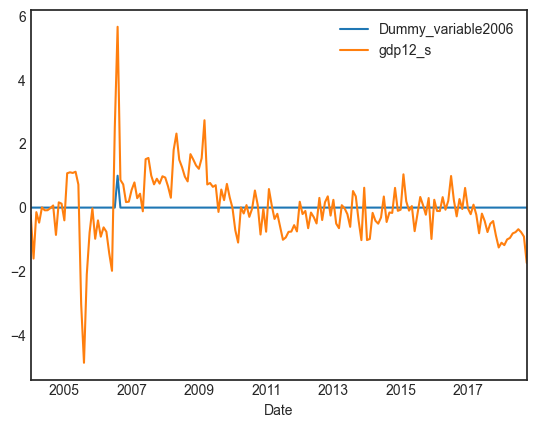

In [226]:
df[['Dummy_variable2006', 'gdp12_s']].plot()

<Axes: xlabel='Date'>

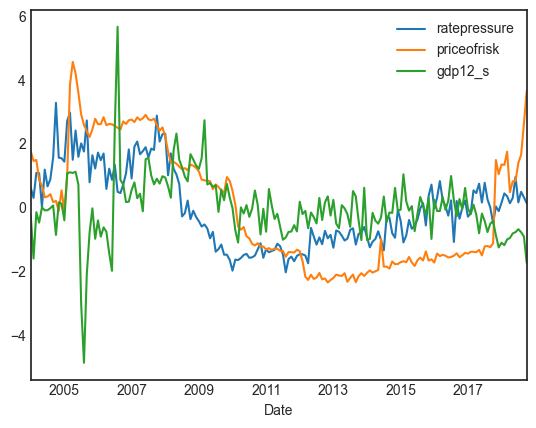

In [227]:
df[['ratepressure', 'priceofrisk', 'gdp12_s']].plot() #Post 2006 price of risk is high, as well as gdp growth, because it is recovering from 2006 war. 2006 war dummy would capture this instead of associatig hogh price of risk with high gdp

In [236]:
indvars = df[['external','priceofrisk', 'gdp_s', 'ratepressure', 'Dummy_variable2006', 'macrodomestic']] #dummy

In [237]:
ql = [0.05, 0.1, 0.5, 0.7, 0.9]

In [238]:
Qresult = QuantileReg('gdp12_s', indvars=indvars , quantile_list=ql, data=df, scaling=True, alpha=0.2)

In [239]:
Qresult.coeff

,quantile,coeff,pval,lower,upper,R2_in_sample,normalized
Intercept,0.05,-1.267456e+00,4.750746e-31,-1.381398,-1.153514,0.261272,True
external,0.05,-6.476930e-01,3.356431e-10,-0.772576,-0.522810,0.261272,True
priceofrisk,0.05,-1.683656e-01,1.001843e-01,-0.299411,-0.037320,0.261272,True
gdp_s,0.05,2.294164e-03,9.586978e-01,-0.054614,0.059203,0.261272,True
ratepressure,0.05,-3.040650e-01,1.604869e-02,-0.464917,-0.143213,0.261272,True
Dummy_variable2006,0.05,4.892912e-01,2.721913e-40,0.453570,0.525012,0.261272,True
macrodomestic,0.05,1.789069e-01,9.749613e-03,0.090852,0.266962,0.261272,True
Intercept,0.1,-7.964696e-01,1.348624e-19,-0.896173,-0.696766,0.182581,True
external,0.1,-5.195628e-01,1.971015e-09,-0.624987,-0.414139,0.182581,True
priceofrisk,0.1,-1.906692e-01,4.696420e-02,-0.313252,-0.068086,0.182581,True


In [240]:
#import os, sys, importlib                             ## Operating system
import pandas as pd                                   ## Dataframes
import numpy as np                                    ## Numeric tools
import matplotlib.pyplot as plt                       ## Plotting
import seaborn as sns                                 ## Plotting
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

In [241]:
#%% Plotting
###############################################################################
## Style of the charts
plt.style.use('seaborn-white')

## Charting parameters : size
from pylab import rcParams
plt.close('all')  

C:\Users\jadfa\AppData\Local\Temp\ipykernel_15844\2319076150.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [242]:
#%% Coefficients plotting
###############################################################################
def coeff_plot(dcoeffc, regressors, qlist):
    plt.close('all')    
    qlist.sort()
    
    for i in range(len(qlist)):
        if qlist[i]==0.5:
            ind05=i
            break
    qlist.insert(ind05,'mean')
    ## Prepare the coefficient frame
#    dcoeff = frames_dict['Quant reg coefficients']
#    dcoeffc = dcoeff[(dcoeff[group] == group_value)]
#    dcoeffc = dcoeffc.rename(columns={'coeff':'standardized coefficient'}) 
    dcoeffc['errors'] = (dcoeffc['upper'] - dcoeffc['lower'])/2

    ## Variables text
    variable_list_coeff = regressors

    #variable_list_label = {'autoregressive':'Autoregressive',
#                           'prices':'Price of Risk',
#                           'quantities': 'Leverage',
#                           'foreign': 'External'}
    
    ## Define the grid
    n=len(variable_list_coeff)
    fig = plt.figure(figsize=(8*min(4,n+1),6*((n+1)//4+1)+4))
    axes=[]
    gs = GridSpec((n+1)//4+1, min(4,n+1))
    for i in range(n+1):
        axes.append(fig.add_subplot(gs[i//4,i%4]))
    ## Plots    
    
    for v, variable in enumerate(variable_list_coeff):
        vs=variable.split('_trans_')
        varn=vs[0]
        if len(vs) > 4 and vs[1][-4:] != 'None':
                varn += '_' + vs[1]
        if len(varn)>20:
            variable_label = varn[:17]+'...'
        else:
            variable_label = varn
            
        dcv = dcoeffc.loc[dcoeffc.index == variable, :].copy()
        dcv = dcv.reset_index()
        dcv = dcv.set_index(dcv['quantile'])
        dcv = dcv.reindex(qlist)
        erna=dcv['errors'].isnull().any()
            # Plot the coefficients
        if erna:
            dcv['coeff'].plot.bar(color='blue',ax=axes[v])
            x=max(abs(min(dcv['coeff'].values)),abs(max(dcv['coeff'].values)))
        else:
            dcv['coeff'].plot.bar(color='blue',yerr = dcv.errors,ax=axes[v])
            x=max(abs(min(dcv['lower'].values)),abs(max(dcv['upper'].values)))
        axes[v].axhline(y=0, c='black', linewidth=0.7)
        axes[v].set_title('{0}'.format(variable_label), fontsize=25, y=1.05)
        axes[v].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axes[v].set_xlabel('')
    
        axes[v].set_ylim(-x-0.1,x+0.1)
        axes[v].tick_params(labelsize=25)
        
        # Plot the R2
    dcv['R2_in_sample'].plot.bar(color='blue', ax=axes[n])
    axes[n].set_title('R2: ', fontsize=25, y=1.05)
    axes[n].set_xlabel('')
    axes[n].tick_params(labelsize=25)
    axes[n].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[n].set_ylim(0,1)
    fig.subplots_adjust(hspace=0.55, wspace=0.25)   
    fig.suptitle('Quantile regressions coefficients', y=1,fontsize=30)
    #plt.text(-19, 1.40, vars_text, fontsize=22, ha='center')
    # fig.savefig('qfit.png')
    # plt.show()

    return(fig)


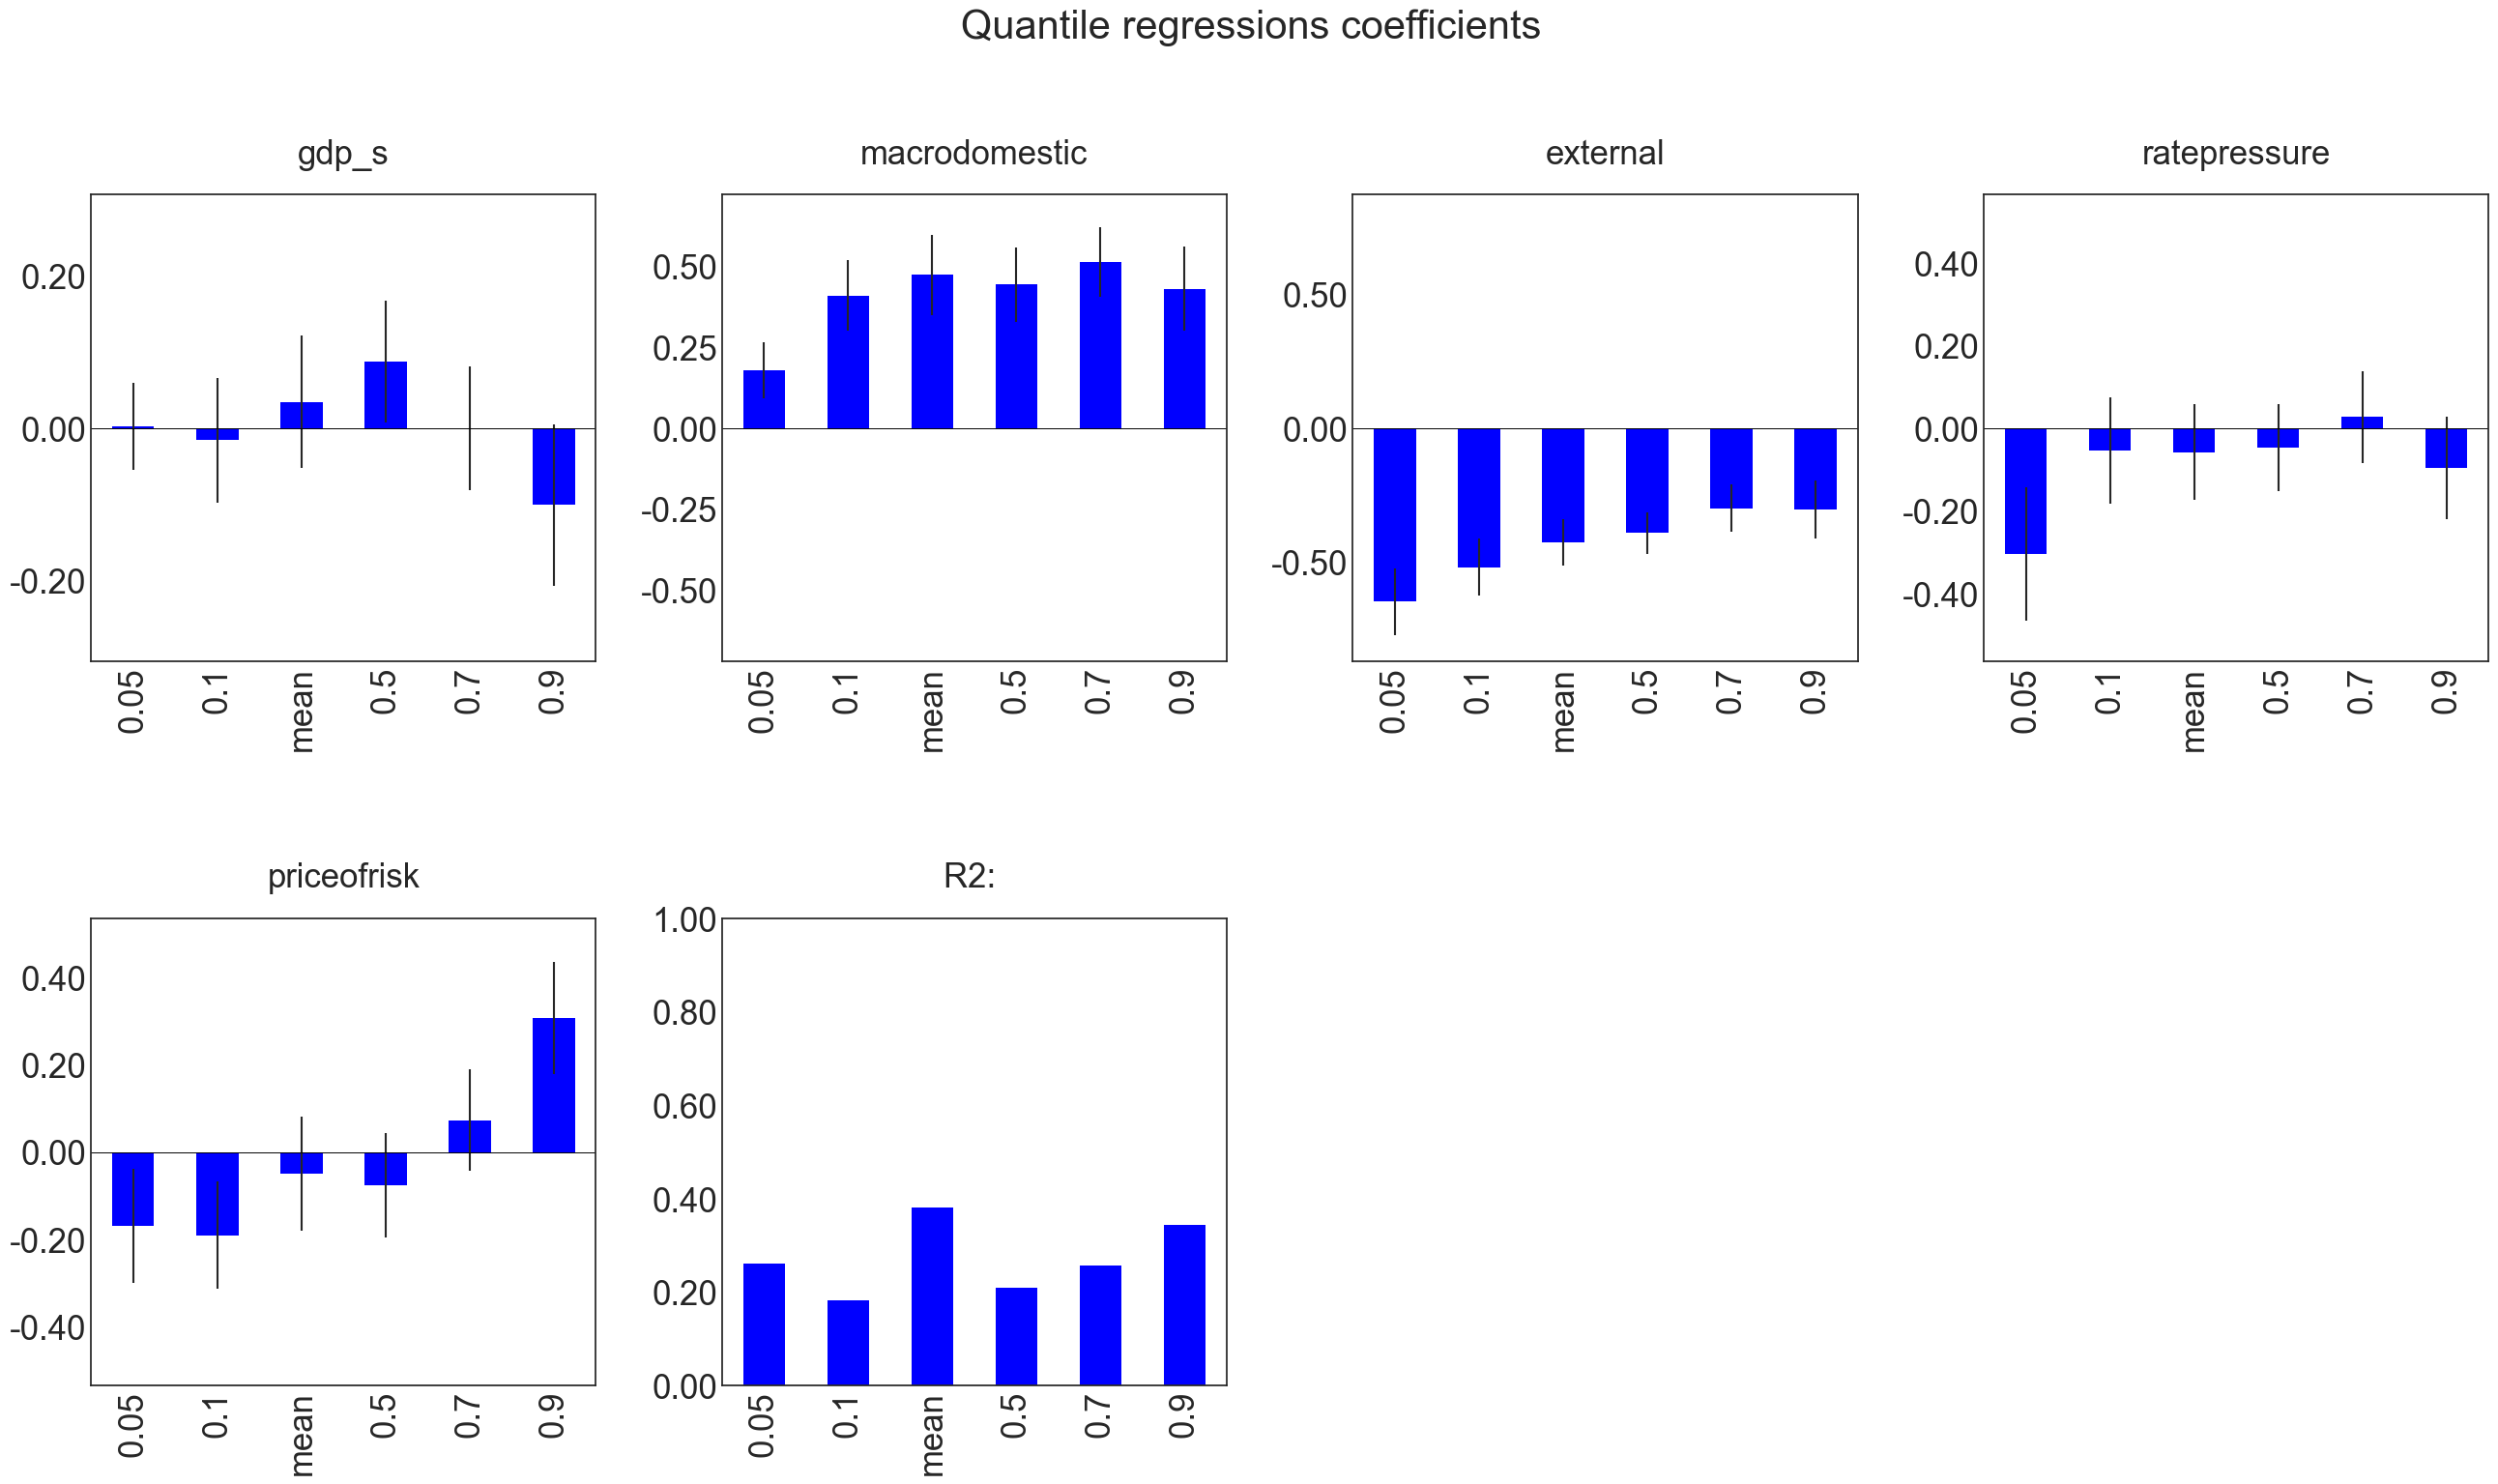

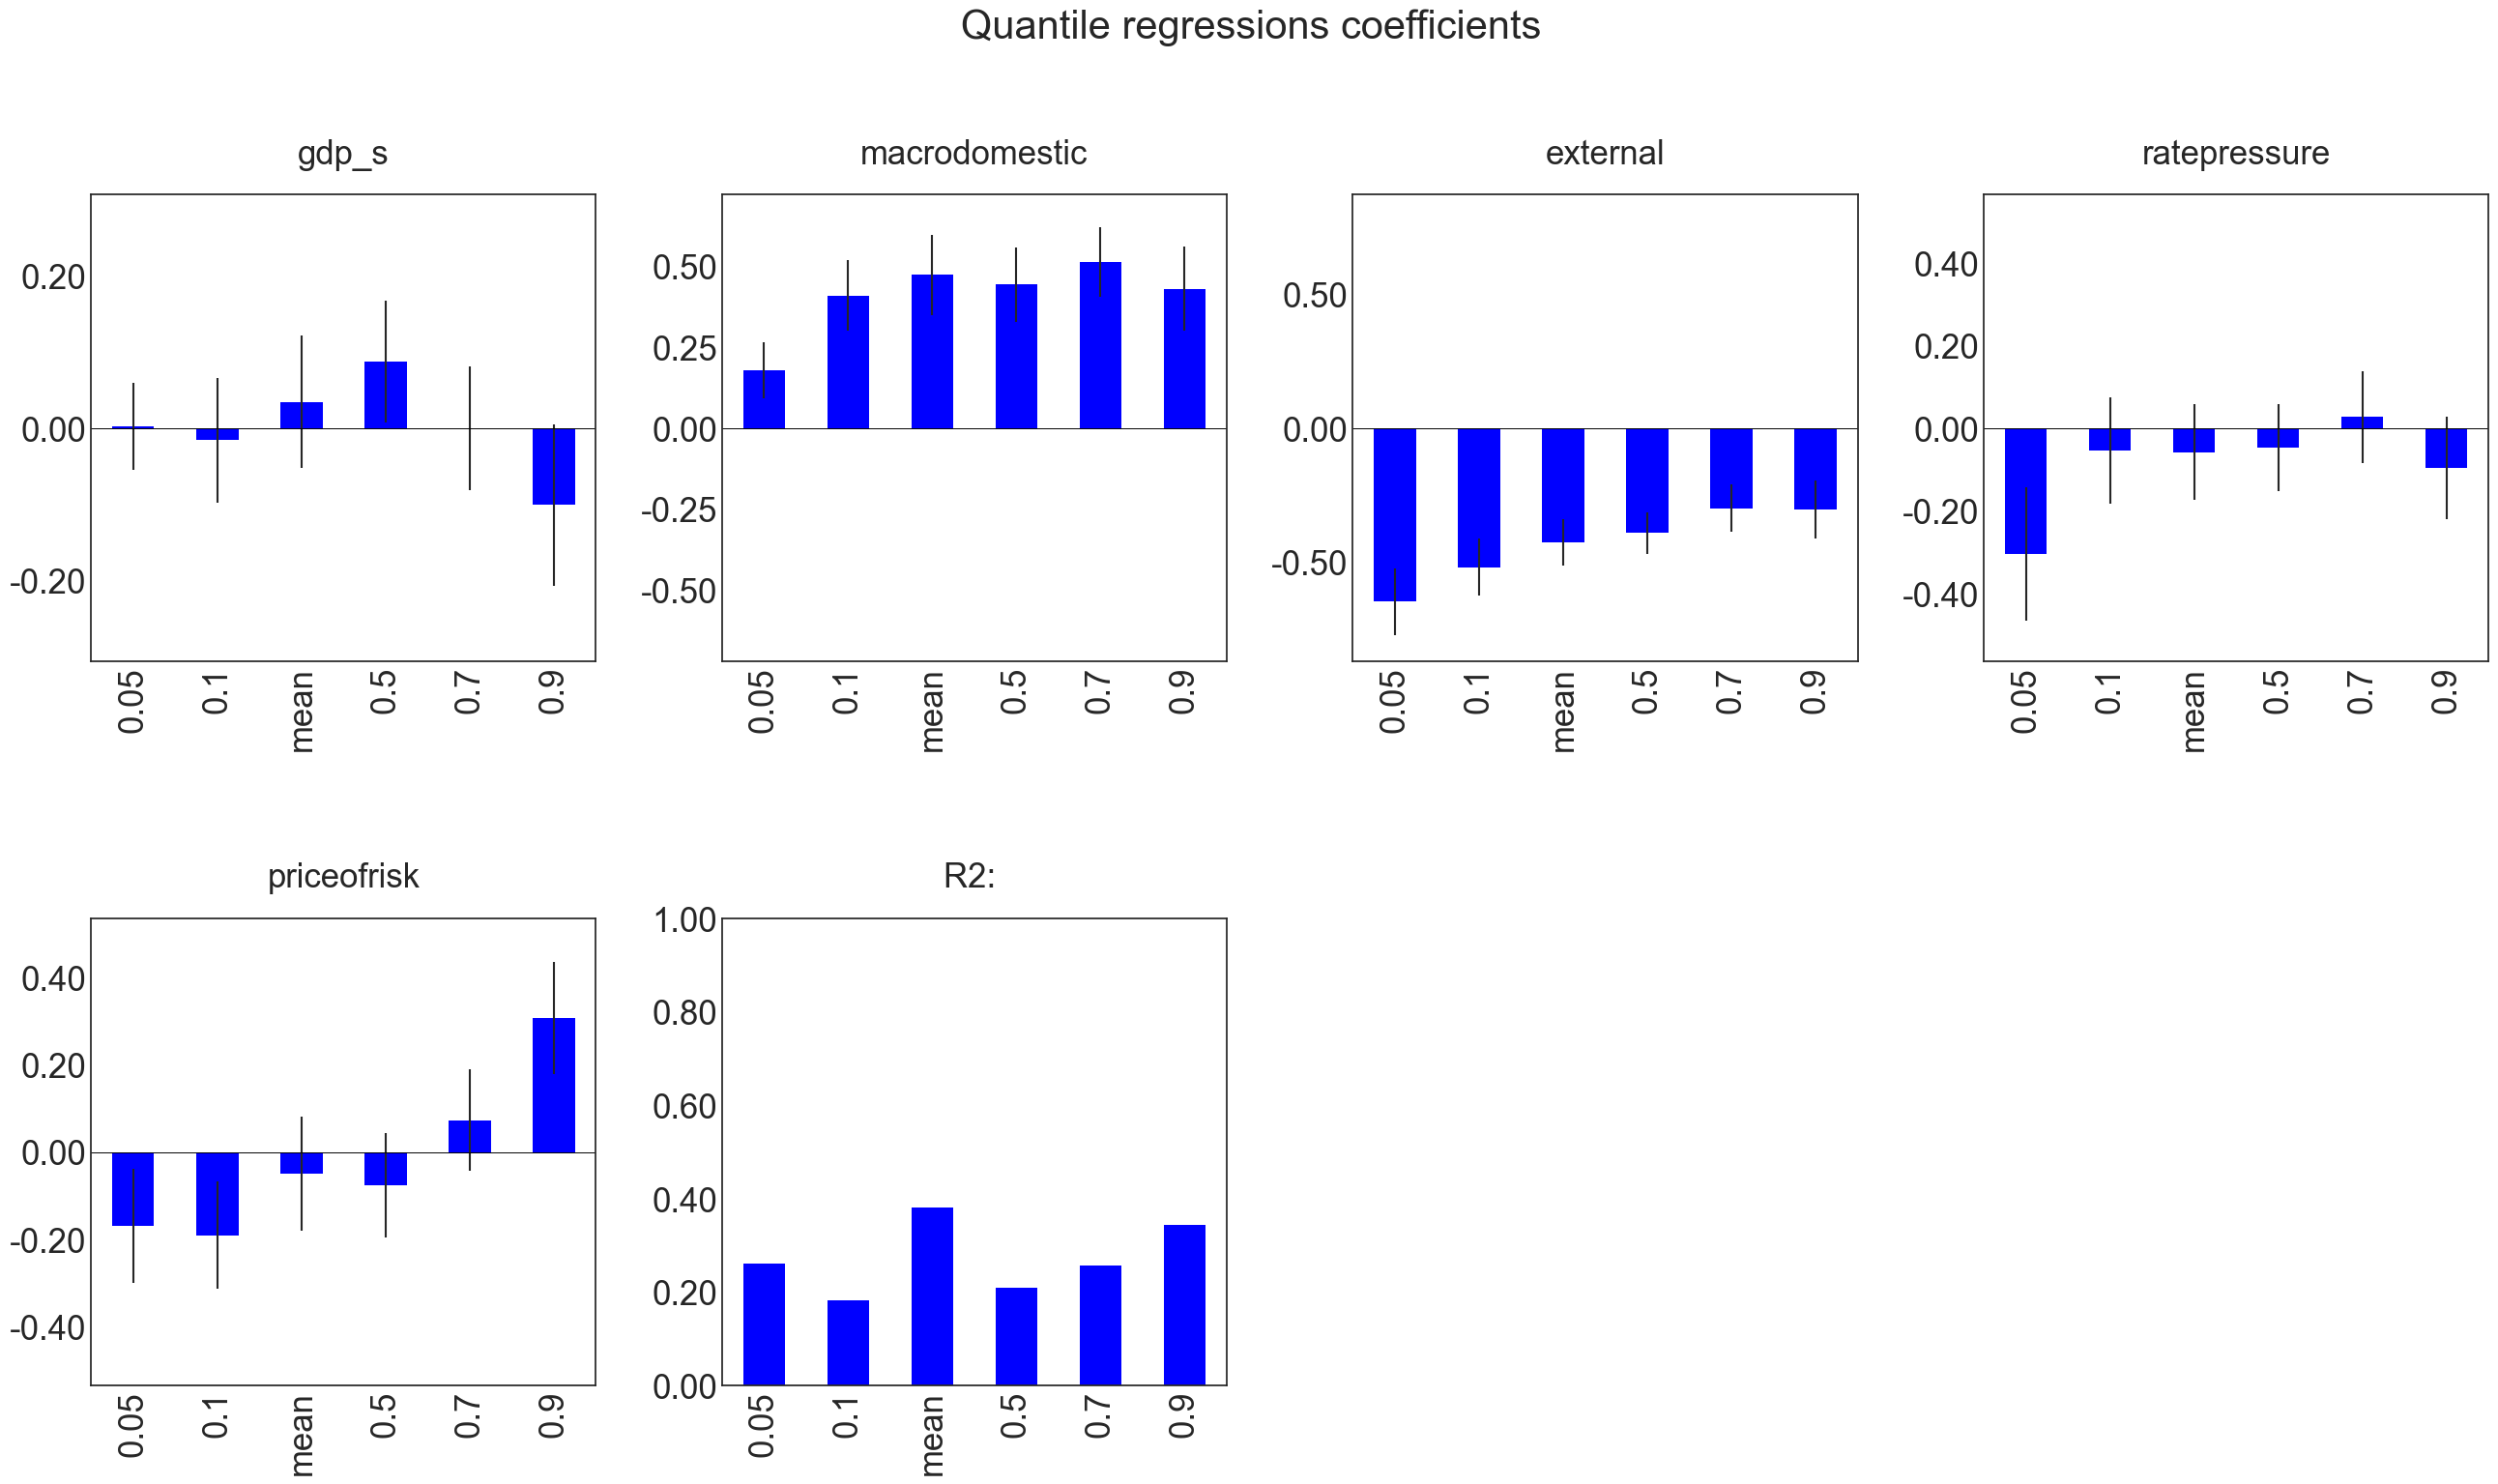

In [243]:
coeff_plot(dcoeffc = Qresult.coeff , regressors = {'external', 'gdp_s', 'priceofrisk', 'ratepressure', 'macrodomestic'}, qlist = [0.05, 0.1, 0.5, 0.7, 0.9])

In [244]:
#Already in 2019-10, one could have assesed the high risks on real activity using financial data which dates to 2018-10. 